In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
import os
import seaborn as sns

In [2]:
normal_file_path = '/Users/shreyamantripragada/Documents/rise2021/data/normal'
schizophrenia_file_path = '/Users/shreyamantripragada/Documents/rise2021/data/schizophrenia'

In [3]:
def reshape_data (file_path): 
    '''
        Given the file_path of the folder, loop through the files within the folder and 
        return a combined dataframe consisting of EEG amplitudes for each patient within a single row.
        
        @param      file_path 
        
    '''
    new_df = pd.DataFrame() # create a new, empty data frame
    filenames = [] # create an empty list which will eventually contain the file names
    
    for filename in os.listdir(file_path): # loop through the files within the folder 
        new_df = new_df.append(pd.read_csv(os.path.join(file_path, filename)).transpose()) # append the values of each file into the data frame
        filenames.append(os.path.splitext(filename)[0]) # append the file names to the list 'filenames'
        
    first_row_values = new_df.index # get the row names and the 
    new_df.insert(loc = 0, column = '0', value = first_row_values) # push the current row indices to the first column
    new_df = new_df.T.reset_index(drop=True).T # reset the column indices
    new_df.index = filenames # reassign the new row indices to the filenames
    
    return new_df, filenames # return the new, combined data frame & filenames

In [4]:
normal_data, norm_filenames = reshape_data(normal_file_path)
schizo_data, schizo_filenames = reshape_data(schizophrenia_file_path)

In [5]:
normal_data['diagnosis'] = 0
schizo_data['diagnosis'] = 1
combined = normal_data
combined = combined.append(schizo_data)
#FINAL_data = combined.sample(frac = 1)
FINAL_data = combined
FINAL_data

,0,1,2,3,4,5,6,7,8,9,...,122871,122872,122873,122874,122875,122876,122877,122878,122879,diagnosis
S42W1,-154.12,-112.09,-154.12,-154.12,-14.01,-51.37,-233.51,-233.51,-112.09,-112.09,...,317.58,616.47,219.5,-233.51,-32.69,158.79,177.47,317.58,126.1,0
S31W,308.45,248.96,328.28,429.63,469.29,429.63,508.94,627.92,887.9,808.58,...,-321.67,-420.82,-491.32,-581.65,-550.81,-451.66,-370.14,-121.18,-50.67,0
S167W1,-91.45,-91.45,-150.39,-231.68,-191.03,-111.77,-30.48,-91.45,-270.29,-331.26,...,138.19,-50.81,-231.68,-591.38,-731.61,-731.61,-611.7,-270.29,-40.64,0
S50W,248.66,229.26,229.26,308.62,449.71,409.15,128.74,29.98,149.9,209.86,...,-430.31,-1010.52,-1171.0,-1331.49,-1331.49,-1070.48,-751.28,98.76,619.01,0
S165W1,8.95,-10.07,-170.04,-250.59,-350.16,-330.02,-151.03,-50.34,8.95,-50.34,...,-130.89,-350.16,-390.43,-210.32,-30.21,219.27,279.68,199.13,99.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33w1,-11.41,-74.18,-171.18,-194.0,-171.18,-154.06,-91.29,-91.29,-74.18,-74.18,...,-450.77,-410.83,-353.77,-194.0,-85.59,39.94,108.41,79.88,45.65,1
382w1,349.76,329.87,149.12,169.91,569.37,729.34,709.45,609.14,569.37,609.14,...,69.59,-210.58,-250.34,-170.81,-90.38,159.97,239.5,-30.73,-310.89,1
103w,-130.55,-30.72,49.92,49.92,8.96,-10.24,8.96,8.96,-151.03,-270.06,...,419.81,319.98,139.51,-340.46,-550.37,-620.76,-481.25,-30.72,139.51,1
307w1,67.98,166.85,247.19,129.78,-173.03,-253.37,-253.37,-234.83,-191.57,-191.57,...,-185.39,-30.9,0.0,-55.62,-12.36,154.49,259.55,438.76,574.72,1


In [6]:
def reduced_data(data):
    '''
        Given the data, iterate through each row, take the absolute value of the EEG amplitudes, 
        and take the average of all the amplitudes for each brain region. For each brain region, append
        the average values into a list and append that list to the 'final_summed_values.'
        
        @param       data     
    '''
    temp_sum = 0
    temp_avg = 0
    values_to_stop = [7679, 15359, 23039, 30719, 38399, 46079, 53759, 61439, 69119, 76799, 84479, 92159, 99839, 107519, 115199, 122879]
    summed_values = []
    final_summed_values = []

    for rows in data.index:
        row_data = [abs(float(x)) for x in data.loc[rows]]
        for index, value in enumerate(row_data):
            if index in values_to_stop:
                temp_avg = temp_sum/7680
                summed_values.append(temp_avg)
                temp_sum = 0
                temp_avg = 0
            else:
                temp_sum += value
        
        final_summed_values.append(summed_values)
        summed_values = []
        
    return final_summed_values

In [7]:
def plot_roc_auc_curve(false_positive_rate, true_positive_rate):  
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return plt

In [8]:
norm_averaged_values = reduced_data(normal_data)
schizo_averaged_values = reduced_data(schizo_data)

In [9]:
reduced_normal_data = pd.DataFrame(norm_averaged_values, columns = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', '01', '02'])
reduced_normal_data['diagnosis'] = 0
reduced_normal_data.index = norm_filenames
reduced_normal_data

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,01,02,diagnosis
S42W1,234.691796,288.619884,297.082391,201.988486,201.117730,308.864366,320.471932,314.160993,196.207816,212.271569,386.414909,366.827124,331.260919,210.572525,316.188987,368.760953,0
S31W,209.802646,310.155904,323.160348,227.777398,275.764142,304.740733,310.459188,285.944573,255.524574,419.788974,457.526612,517.576155,517.303068,475.087018,422.721320,486.114878,0
S167W1,352.218137,434.144626,355.861077,446.941460,369.187810,351.056225,401.587008,343.221223,281.817039,303.818939,392.647286,431.740410,393.273398,387.944044,542.842977,536.968509,0
S50W,269.647852,338.634255,344.864874,234.133116,256.133755,368.086639,368.735112,355.779238,234.084414,258.421585,391.401720,409.314609,358.623829,293.393776,625.496439,629.259563,0
S165W1,205.958906,257.508954,265.755559,242.377389,203.218307,274.589074,278.940344,279.626380,257.992473,213.305772,249.756887,298.145780,280.551883,300.361348,294.697612,314.157604,0
s158w1,210.156392,243.122535,242.398858,236.778044,206.025147,252.486010,265.404565,246.924285,232.915249,209.578012,267.934919,294.790904,314.715503,271.258555,327.399674,450.594164,0
s178w1,233.345544,262.343376,276.535676,240.188206,236.186406,256.556363,262.057082,270.026048,233.934716,231.208828,275.671909,274.158747,293.347750,225.355462,362.525708,455.596702,0
S18W1,183.823220,208.668583,246.833941,204.128240,142.202448,237.652893,316.793198,238.867346,200.856008,168.485749,292.000155,320.969673,275.168212,201.090997,412.535669,398.371788,0
s27w1,287.675622,325.139793,283.005382,240.012783,245.015546,307.517049,321.980163,294.850973,175.702001,285.849380,412.084990,477.351270,397.399457,239.099220,578.065659,598.894160,0
S163W1,207.762145,260.002005,256.324676,197.574137,248.676862,276.740984,286.515740,267.751495,196.478302,284.604995,321.380874,320.558260,332.958268,206.182699,413.562566,343.096845,0


In [10]:
reduced_schizo_data = pd.DataFrame(schizo_averaged_values, columns = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', '01', '02'])
reduced_schizo_data['diagnosis'] = 1
reduced_schizo_data.index = schizo_filenames
reduced_schizo_data

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,01,02,diagnosis
312w1,206.320397,281.263372,299.172999,257.392182,211.820132,294.820716,319.786544,345.369290,272.147546,276.660156,449.150581,524.197324,523.097816,435.508664,603.983848,633.859315,1
642w1,366.396354,382.963122,418.888553,297.033108,282.734802,330.218452,328.949447,336.694488,316.450935,238.148698,247.791669,248.684117,263.109678,262.007634,296.003741,254.928184,1
387-02w1,234.795503,287.451087,178.627186,193.460809,207.708783,281.326902,286.289586,265.439389,262.181173,202.033771,284.241773,292.374388,285.597331,281.038923,293.338473,280.024243,1
s351w,235.326948,276.417191,303.862620,242.048113,224.213878,278.223172,293.151385,310.499721,301.374194,240.573027,288.047160,288.309579,360.355677,326.735962,309.567799,414.304186,1
423w,271.413695,319.346132,293.445698,245.076982,251.858844,240.822275,274.157577,264.048354,225.329668,226.555383,242.301031,260.228691,260.978638,231.488794,285.456193,283.472827,1
485w1,321.123158,366.058307,315.590077,230.039855,273.682033,379.195359,392.642043,379.276591,237.137714,218.613786,365.679971,490.870199,497.869384,373.756691,468.536046,523.482060,1
314w1,188.503249,206.377499,210.450124,157.257440,197.954727,250.850112,257.437574,244.540417,166.504868,236.484505,325.113289,350.156646,336.925900,232.581078,432.306539,371.034786,1
585w1,256.471974,187.546342,229.976701,251.165103,284.208555,328.489284,306.831605,330.613654,282.786000,281.657758,285.789540,337.777720,296.233518,261.141142,425.521574,420.625659,1
113w1,311.777220,282.284711,243.702085,209.386413,230.519184,202.143195,215.298730,266.146725,219.864124,197.267254,204.431280,225.165079,291.204492,237.693068,257.713474,343.016491,1
156w1,173.870172,221.301829,201.075190,151.966254,195.879945,270.835018,283.097083,276.803309,190.147621,179.189104,360.347039,419.801158,408.060797,261.521094,469.821441,514.013210,1


In [11]:
combined_data = reduced_normal_data
combined_data = combined_data.append(reduced_schizo_data)
#final_data = combined_data.sample(frac = 1)
final_data = combined_data
final_data

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,01,02,diagnosis
S42W1,234.691796,288.619884,297.082391,201.988486,201.117730,308.864366,320.471932,314.160993,196.207816,212.271569,386.414909,366.827124,331.260919,210.572525,316.188987,368.760953,0
S31W,209.802646,310.155904,323.160348,227.777398,275.764142,304.740733,310.459188,285.944573,255.524574,419.788974,457.526612,517.576155,517.303068,475.087018,422.721320,486.114878,0
S167W1,352.218137,434.144626,355.861077,446.941460,369.187810,351.056225,401.587008,343.221223,281.817039,303.818939,392.647286,431.740410,393.273398,387.944044,542.842977,536.968509,0
S50W,269.647852,338.634255,344.864874,234.133116,256.133755,368.086639,368.735112,355.779238,234.084414,258.421585,391.401720,409.314609,358.623829,293.393776,625.496439,629.259563,0
S165W1,205.958906,257.508954,265.755559,242.377389,203.218307,274.589074,278.940344,279.626380,257.992473,213.305772,249.756887,298.145780,280.551883,300.361348,294.697612,314.157604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33w1,133.813852,187.700915,214.031283,163.609798,143.845639,202.366174,233.904637,213.592914,182.788525,228.681643,206.899651,229.157174,210.288310,193.091059,295.865714,295.083444,1
382w1,242.587595,230.059819,247.661365,230.707720,207.313741,249.410504,245.569738,247.023559,206.229312,161.192517,239.384986,268.091678,271.596783,251.919185,276.751926,301.223745,1
103w,163.103329,191.815826,195.462292,155.599866,163.146695,220.531592,253.294411,214.071590,153.416366,183.092314,318.559745,333.569794,328.175471,225.947617,313.374033,396.105128,1
307w1,249.677092,278.756457,250.845298,233.203164,244.705039,306.153452,303.798953,263.455901,236.327749,237.826767,355.031556,357.035163,338.611685,320.717762,362.815018,521.262616,1


In [12]:
X = FINAL_data.values
Y = FINAL_data['diagnosis']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [13]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

roc_auc_score 0.6153846153846154


<module 'matplotlib.pyplot' from '/Users/shreyamantripragada/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

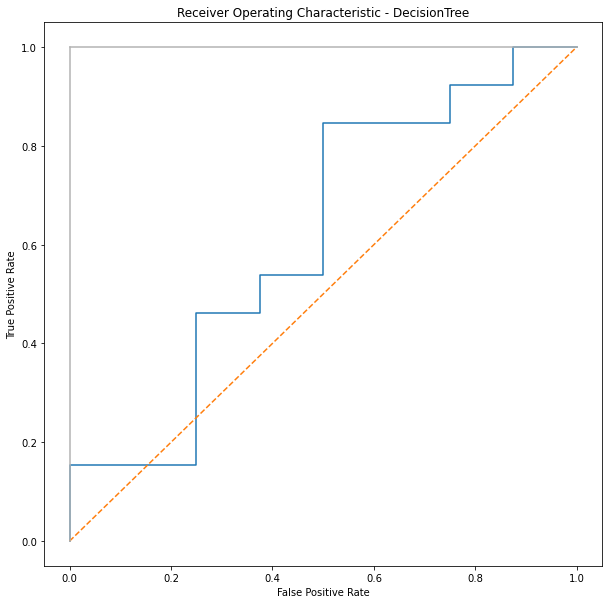

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

index_list = []
count = 0

for index in final_data.index:
    index_list.append([final_data.loc[index]])
        
classifier = LogisticRegression(random_state = 0, class_weight = "balanced") #look into parameters
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(Y_test, y_score)

print('roc_auc_score', roc_auc_score(Y_test, y_score))

plot_roc_auc_curve(false_positive_rate, true_positive_rate)

#print('Logistic Regression', roc_auc_score(Y_test, classifier.predict(X_test)))

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

model = RandomForestRegressor()
model.fit(X_train, Y_train)
#names = 

#print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             #reverse=True)

#sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
#sel.fit(X_train, Y_train)

#selected_feat= X_train.columns[(sel.get_support())]
#len(selected_feat)

#print(selected_feat)

RandomForestRegressor()

                                                                      fpr  \
classifiers                                                                 
LogisticRegression      [0.0, 0.0, 0.0, 0.25, 0.25, 0.375, 0.375, 0.5,...   
SVC                                                     [0.0, 0.625, 1.0]   
KNeighborsClassifier                                     [0.0, 0.25, 1.0]   
GaussianNB                                                [0.0, 0.0, 1.0]   
RandomForestClassifier  [0.0, 0.0, 0.0, 0.25, 0.25, 0.25, 0.375, 0.375...   

                                                                      tpr  \
classifiers                                                                 
LogisticRegression      [0.0, 0.07692307692307693, 0.15384615384615385...   
SVC                                        [0.0, 0.8461538461538461, 1.0]   
KNeighborsClassifier                       [0.0, 0.3076923076923077, 1.0]   
GaussianNB                                                [0.0, 1.0, 1.0]  

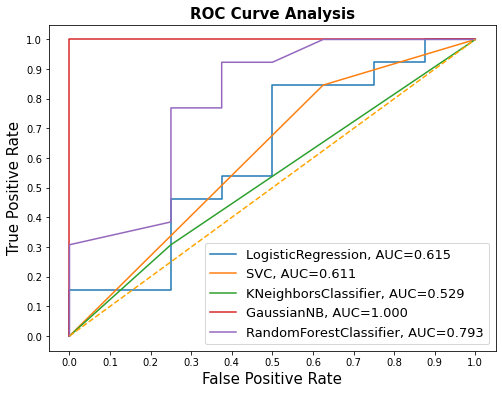

In [18]:
## IGNORE THIS!!!

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC

classifiers = [LogisticRegression(random_state=1234), SVC(kernel='linear'), KNeighborsClassifier(), GaussianNB(),
               RandomForestClassifier(random_state=1234)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for index, cls in enumerate(classifiers):
    model = cls.fit(X_train, Y_train)
    
    if index == 1:
        yproba = model.predict(X_test)
    else:
        yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(Y_test,  yproba)
    auc = roc_auc_score(Y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__, 'fpr':fpr, 'tpr':tpr,'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

print (result_table)

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

    

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)

roc_auc_score(Y_test, y_score) (array([0.   , 0.   , 0.   , 0.25 , 0.25 , 0.375, 0.375, 0.5  , 0.5  ,
       0.75 , 0.75 , 0.875, 0.875, 1.   ]), array([0.        , 0.07692308, 0.15384615, 0.15384615, 0.46153846,
       0.46153846, 0.53846154, 0.53846154, 0.84615385, 0.84615385,
       0.92307692, 0.92307692, 1.        , 1.        ]), array([1.99995586, 0.99995586, 0.99000412, 0.96029826, 0.79477011,
       0.78507029, 0.67787439, 0.66055514, 0.5679729 , 0.49906652,
       0.49566944, 0.2900975 , 0.22880206, 0.11846892]))


<module 'matplotlib.pyplot' from '/Users/shreyamantripragada/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

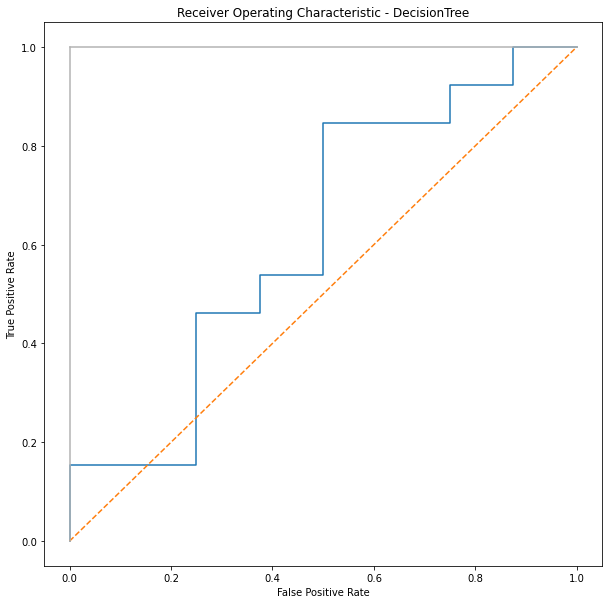

In [20]:
y_score = grid_result.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test, y_score)
print ('roc_auc_score(Y_test, y_score)', roc_curve(Y_test, y_score))
plot_roc_auc_curve(false_positive_rate, true_positive_rate)

In [21]:
from sklearn.linear_model import LinearRegression
classifier = LinearRegression() #look into parameters
classifier.fit(X_train, Y_train)
#y_score = classifier.predict_proba(X_test)[:,1]
#false_positive_rate, true_positive_rate = roc_curve(Y_test, y_score)

#print('roc_auc_score', roc_auc_score(Y_test, y_score))

#plot_roc_auc_curve(false_positive_rate, true_positive_rate)

LinearRegression()

roc_auc_score 0.4951923076923077


<module 'matplotlib.pyplot' from '/Users/shreyamantripragada/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

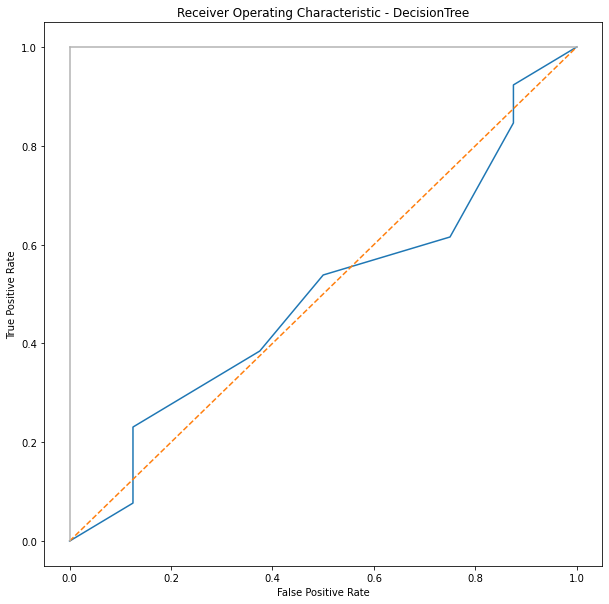

In [22]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test, y_score)

print('roc_auc_score', roc_auc_score(Y_test, y_score))

plot_roc_auc_curve(false_positive_rate, true_positive_rate)



In [23]:
#Using Logistic Regression Algorithm to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, Y_train)
print('Logistic Regression', roc_auc_score(Y_test, classifier.predict(X_test)))


#Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, Y_train)

#Using SVC method of svm class to use Support Vector Machine Algorithm
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, Y_train)

#Using SVC method of svm class to use Kernel SVM Algorithm
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, Y_train)

#Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, Y_train)

#Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)

#Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)

Logistic Regression 0.5865384615384616


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [24]:
FINAL_data.head()

,0,1,2,3,4,5,6,7,8,9,...,122871,122872,122873,122874,122875,122876,122877,122878,122879,diagnosis
S42W1,-154.12,-112.09,-154.12,-154.12,-14.01,-51.37,-233.51,-233.51,-112.09,-112.09,...,317.58,616.47,219.5,-233.51,-32.69,158.79,177.47,317.58,126.1,0
S31W,308.45,248.96,328.28,429.63,469.29,429.63,508.94,627.92,887.9,808.58,...,-321.67,-420.82,-491.32,-581.65,-550.81,-451.66,-370.14,-121.18,-50.67,0
S167W1,-91.45,-91.45,-150.39,-231.68,-191.03,-111.77,-30.48,-91.45,-270.29,-331.26,...,138.19,-50.81,-231.68,-591.38,-731.61,-731.61,-611.7,-270.29,-40.64,0
S50W,248.66,229.26,229.26,308.62,449.71,409.15,128.74,29.98,149.9,209.86,...,-430.31,-1010.52,-1171.0,-1331.49,-1331.49,-1070.48,-751.28,98.76,619.01,0
S165W1,8.95,-10.07,-170.04,-250.59,-350.16,-330.02,-151.03,-50.34,8.95,-50.34,...,-130.89,-350.16,-390.43,-210.32,-30.21,219.27,279.68,199.13,99.57,0


In [25]:
#TEMP = FINAL_data
#TEMP.loc['S42W1',0] = TEMP.loc['S42W1',0].replace(TEMP.loc['S42W1',0], "1, 2, 3")

#TEMP.at['S42W1', 0] = np.asarray(added_list)
#TEMP.at['S42W1', 0] = -154.12

listed_DF = pd.DataFrame().reindex_like(final_data)
#listed_DF.at['S42W1', 0] = -154.12

listed_DF
#DataFrame.replace(to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad')[source]

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,01,02,diagnosis
S42W1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S31W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S167W1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S50W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S165W1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33w1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382w1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307w1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
#FINAL_data - original & final_data - condensed 
values_to_stop = [7679, 15359, 23039, 30719, 38399, 46079, 53759, 61439, 69119, 76799, 84479, 92159, 99839, 107519, 115199, 122879]
added_list = []
row_names = FINAL_data.index
count = 0
col_index = 0

for rows in FINAL_data.index:
    row_data = [float(x) for x in FINAL_data.loc[rows]]
    #print ('patient')
    for cols, value in enumerate(row_data):
        if cols in values_to_stop and count < 84:
            #print ('cols', cols, 'value', value)
            #print ('shape', np.asarray(added_list).shape)
            print ('array content', np.asarray(added_list)[0])
            listed_DF.at[row_names[count], col_index] = list(added_list)
            col_index += 1
            added_list.clear()
        else:
            added_list.append(value)
    count += 1


array content -154.12


ValueError: setting an array element with a sequence.

In [152]:
listed_DF

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
S42W1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S31W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S167W1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S50W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S165W1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33w1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382w1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307w1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
values_to_stop = [7679, 15359, 23039, 30719, 38399, 46079, 53759, 61439, 69119, 76799, 84479, 92159, 99839, 107519, 115199, 122879]
brain_regions = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', '01', '02']
row_names = final_data.index
temp_list = []
listed_DF = pd.DataFrame().reindex_like(final_data)
listed_DF.head()
row_count = 0
col_count = 0

for rows in FINAL_data.index:
    row_data = [float(x) for x in FINAL_data.loc[rows]]
    
    for index, value in enumerate(row_data):
        if index in values_to_stop:
            
            #print ('row_names[row_count]', row_names[row_count])
            #print ('brain_regions[col_count]', brain_regions[col_count])
            #print ('temp_list', temp_list)
            temp_DF.at[row_names[row_count], brain_regions[col_count]] = temp_list
            col_count += 1
            temp_list = []
        else:
            temp_list.append(value)
            
    row_count += 1

temp_DF

NameError: name 'temp_DF' is not defined

In [81]:
final_data

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,01,02,diagnosis
S42W1,234.691796,288.619884,297.082391,201.988486,201.117730,308.864366,320.471932,314.160993,196.207816,212.271569,386.414909,366.827124,331.260919,210.572525,316.188987,368.760953,0
S31W,209.802646,310.155904,323.160348,227.777398,275.764142,304.740733,310.459188,285.944573,255.524574,419.788974,457.526612,517.576155,517.303068,475.087018,422.721320,486.114878,0
S167W1,352.218137,434.144626,355.861077,446.941460,369.187810,351.056225,401.587008,343.221223,281.817039,303.818939,392.647286,431.740410,393.273398,387.944044,542.842977,536.968509,0
S50W,269.647852,338.634255,344.864874,234.133116,256.133755,368.086639,368.735112,355.779238,234.084414,258.421585,391.401720,409.314609,358.623829,293.393776,625.496439,629.259563,0
S165W1,205.958906,257.508954,265.755559,242.377389,203.218307,274.589074,278.940344,279.626380,257.992473,213.305772,249.756887,298.145780,280.551883,300.361348,294.697612,314.157604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33w1,133.813852,187.700915,214.031283,163.609798,143.845639,202.366174,233.904637,213.592914,182.788525,228.681643,206.899651,229.157174,210.288310,193.091059,295.865714,295.083444,1
382w1,242.587595,230.059819,247.661365,230.707720,207.313741,249.410504,245.569738,247.023559,206.229312,161.192517,239.384986,268.091678,271.596783,251.919185,276.751926,301.223745,1
103w,163.103329,191.815826,195.462292,155.599866,163.146695,220.531592,253.294411,214.071590,153.416366,183.092314,318.559745,333.569794,328.175471,225.947617,313.374033,396.105128,1
307w1,249.677092,278.756457,250.845298,233.203164,244.705039,306.153452,303.798953,263.455901,236.327749,237.826767,355.031556,357.035163,338.611685,320.717762,362.815018,521.262616,1


In [82]:
FINAL_data

,0,1,2,3,4,5,6,7,8,9,...,122871,122872,122873,122874,122875,122876,122877,122878,122879,diagnosis
S42W1,-154.12,-112.09,-154.12,-154.12,-14.01,-51.37,-233.51,-233.51,-112.09,-112.09,...,317.58,616.47,219.5,-233.51,-32.69,158.79,177.47,317.58,126.1,0
S31W,308.45,248.96,328.28,429.63,469.29,429.63,508.94,627.92,887.9,808.58,...,-321.67,-420.82,-491.32,-581.65,-550.81,-451.66,-370.14,-121.18,-50.67,0
S167W1,-91.45,-91.45,-150.39,-231.68,-191.03,-111.77,-30.48,-91.45,-270.29,-331.26,...,138.19,-50.81,-231.68,-591.38,-731.61,-731.61,-611.7,-270.29,-40.64,0
S50W,248.66,229.26,229.26,308.62,449.71,409.15,128.74,29.98,149.9,209.86,...,-430.31,-1010.52,-1171.0,-1331.49,-1331.49,-1070.48,-751.28,98.76,619.01,0
S165W1,8.95,-10.07,-170.04,-250.59,-350.16,-330.02,-151.03,-50.34,8.95,-50.34,...,-130.89,-350.16,-390.43,-210.32,-30.21,219.27,279.68,199.13,99.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33w1,-11.41,-74.18,-171.18,-194.0,-171.18,-154.06,-91.29,-91.29,-74.18,-74.18,...,-450.77,-410.83,-353.77,-194.0,-85.59,39.94,108.41,79.88,45.65,1
382w1,349.76,329.87,149.12,169.91,569.37,729.34,709.45,609.14,569.37,609.14,...,69.59,-210.58,-250.34,-170.81,-90.38,159.97,239.5,-30.73,-310.89,1
103w,-130.55,-30.72,49.92,49.92,8.96,-10.24,8.96,8.96,-151.03,-270.06,...,419.81,319.98,139.51,-340.46,-550.37,-620.76,-481.25,-30.72,139.51,1
307w1,67.98,166.85,247.19,129.78,-173.03,-253.37,-253.37,-234.83,-191.57,-191.57,...,-185.39,-30.9,0.0,-55.62,-12.36,154.49,259.55,438.76,574.72,1
